# Using Dask within an HPC Environment
### RMACC 2022 Tutorial | 4 August, 2022

<img src=images/NCAR-contemp-logo-blue.png width=500px alt="NCAR Logo">

Brian Vanderwende  
HPC User Support Consultant  
[vanderwb@ucar.edu](mailto:vanderwb@ucar.edu)
---

#### Setting up Python to run Dask

The `miniconda` package environment manager makes it very easy to deploy Dask anywhere.

1. If conda is not available on your system, first install it:

```
# For example - on x86 Linux platforms
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
bash Miniconda3-latest-Linux-x86_64.sh
# Now start a new shell to finish conda integration into your environment
```

2. Use conda (or mamba) to create a new Python environment with required and [useful] packages:

```
conda create -n my-dask-env -c conda-forge dask dask-jobqueue [matplotlib python-graphviz jupyterlab ipywidgets dask-labextension globus-cli]
```

3. Activate the environment and run `python`, `ipython`, or use in Jupyter as a language kernel

#### Downloading the dataset

If you wish to follow along during or after the tutorial session, you will need to download the data we use in the following commands. I have made these data available via a Globus endpoint, which you can access at https://www.globus.org. Search for the *collection* called `RMACC 2022 - HPC Dask Tutorial` and download the data to the main directory of the GitHub repo (the one containing this notebook).

## Arrays, series, and dataframes - why we like Dask
Complex data structures enable data science in Python:
* [NumPy arrays](https://numpy.org/doc/stable/)
* [Pandas series and dataframes](https://pandas.pydata.org/)
* [XArray arrays](https://docs.xarray.dev/)

*But datasets are getting larger all of the time! What if my data science is too big to fit into memory, or takes too long to complete an analysis?*

### Dask increases the size of possible work from *fits-in-memory* to *fits-on-disk* (sometimes doing it faster) via distributed parallelism

That said, **Dask should only be used when necessary as it incurs overhead.** Avoid Dask if you can easily:
* Speed up your code with use of compiled routines in libraries like NumPy
* Profile and optimize your serial code to minimize bottlenecks
* Read in a subset of data to gain the insight you need

## Warming up with some Pandas


In [1]:
# Make plots display inline in the notebook
%matplotlib inline

At NCAR, we have created a nice utility called `qhist` to provide historical data on interactive and batch compute jobs.

#### Load historical job data from 2022 June

In [2]:
import pandas as pd
june_jobs = pd.read_csv('data/jobs-202206.dat')
jj = june_jobs

In [3]:
# Display the top five rows of the dataframe
jj.head()

,Job ID,Queue,Nodes,NCPUs,NGPUs,Req Mem (GB),Used Mem(GB),Job Submit,Job Start,Job End,Walltime (h),Exit Status,Job Name
0,3249133.casper-pbs,htc,1,1,0,10.0,0.0,2022-06-30T23:55:45,2022-06-30T23:57:35,2022-06-30T23:57:46,0.17,0,q_merge_and_scp
1,3249131.casper-pbs,gpgpu,1,1,1,10.0,0.2,2022-06-30T23:55:45,2022-06-30T23:55:47,2022-06-30T23:57:36,1.00,0,q_pipesubmit
2,3248931.casper-pbs,htc,1,2,0,1.0,0.0,2022-06-30T22:50:45,2022-06-30T23:57:07,2022-06-30T23:57:11,1.00,0,RRLXfer
3,3248928.casper-pbs,htc,1,1,0,1.0,0.0,2022-06-30T22:50:40,2022-06-30T22:50:41,2022-06-30T23:57:08,9.00,0,RR_FINN_Listen
4,3249132.casper-pbs,gpgpu,1,1,1,10.0,0.2,2022-06-30T23:55:45,2022-06-30T23:55:47,2022-06-30T23:57:00,1.00,0,q_cat_pipesubmit


#### How many jobs did users run in June?

In [4]:
len(jj)

866000

#### How many jobs ran in each queue?

In [5]:
# Create a "groupby object" based on the selected columns
# which can return info like the count of each type of the column value
jj.groupby('Queue').size()

Queue
R3073777          4
S870294         267
a100              6
asdgpu          104
gpgpu          2307
htc          838269
jhublogin       890
largemem        234
rda           22429
system            1
tdd             780
vis             709
dtype: int64

<AxesSubplot:xlabel='Queue'>

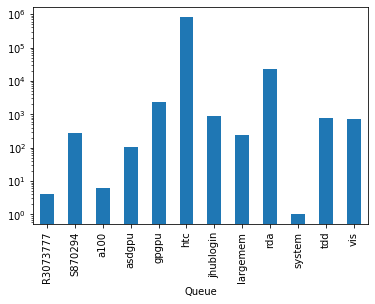

In [6]:
# Here we easily plot the prior data using matplotlib from pandas
jj.groupby('Queue').size().plot.bar(logy = True)

#### Where do Dask jobs run?

In [7]:
# Select only one column of data
jj['Job Name'].head()

0     q_merge_and_scp
1        q_pipesubmit
2             RRLXfer
3      RR_FINN_Listen
4    q_cat_pipesubmit
Name: Job Name, dtype: object

In [8]:
# Get the number of each value in Job Name (similar to size above)
jj['Job Name'].value_counts().head()

job                        429003
mpas_real-time_graphics    185963
dask-worker                 20125
dsrqst                      19650
gfs_real-time_graphics      17280
Name: Job Name, dtype: int64

In [9]:
# Create a new dataframe of job entries with the Job Name "dask-worker"
dj = jj[jj['Job Name'] == 'dask-worker']
dj.groupby('Queue').size()

Queue
htc         20081
largemem        1
tdd            43
dtype: int64

*Is this what we expect? Dask tasks tend to be **bursty, high-throughput** computing.*

#### What are typical worker CPU and memory needs?

In [10]:
# groupby operations can be on multiple columns and ones generated by manipulating a column
dj.groupby(['NCPUs', dj['Req Mem (GB)'] // 10 * 10]).size()

NCPUs  Req Mem (GB)
1      0.0              696
       10.0            2791
       20.0            5865
       30.0             220
       40.0              60
       50.0             886
       60.0              50
       70.0              20
       100.0           5345
       110.0             20
       200.0             61
       220.0            185
       250.0           1310
       320.0            164
       330.0             16
       350.0             16
       420.0              1
2      20.0              12
       250.0            339
4      10.0              12
       40.0             735
5      10.0              25
       100.0             10
6      100.0              1
9      250.0             72
10     100.0              4
12     200.0              1
       300.0            700
18     200.0             34
       300.0              7
24     200.0              4
36     100.0            110
       300.0            353
dtype: int64

#### How much of the request memory is wasted?

In [11]:
# Creating a new column
dj['Unused Mem'] = dj['Req Mem (GB)'] - dj['Used Mem(GB)']

TypeError: unsupported operand type(s) for -: 'float' and 'str'

In [12]:
# Check all datatypes of the dataframe (here we see usedmem did not get interpreted properly)
dj.dtypes

Job ID           object
Queue            object
Nodes             int64
NCPUs             int64
NGPUs             int64
Req Mem (GB)    float64
Used Mem(GB)     object
Job Submit       object
Job Start        object
Job End          object
Walltime (h)    float64
Exit Status       int64
Job Name         object
dtype: object

In [13]:
# Let's cast used mem as the dtype that we want (float)
dj['Used Mem(GB)'] = dj['Used Mem(GB)'].astype(float)

/glade/scratch/vanderwb/temp/ipykernel_268948/1533624428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dj['Used Mem(GB)'] = dj['Used Mem(GB)'].astype(float)


In [14]:
# To avoid the above problem, we need to make sure we copy data in our dask job dataframe, and not reference it
dj = jj[jj['Job Name'] == 'dask-worker'].copy()
dj['Used Mem(GB)'] = dj['Used Mem(GB)'].astype(float)
dj.dtypes

Job ID           object
Queue            object
Nodes             int64
NCPUs             int64
NGPUs             int64
Req Mem (GB)    float64
Used Mem(GB)    float64
Job Submit       object
Job Start        object
Job End          object
Walltime (h)    float64
Exit Status       int64
Job Name         object
dtype: object

In [15]:
dj['Unused Mem (%)'] = (dj['Req Mem (GB)'] - dj['Used Mem(GB)']) / dj['Req Mem (GB)'] * 100.0

<AxesSubplot:xlabel='% Unused', ylabel='Number of Jobs'>

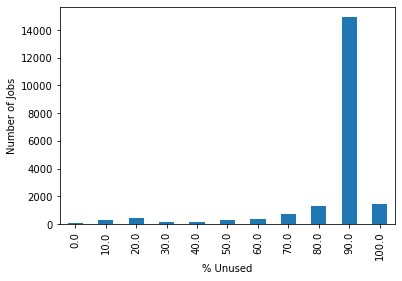

In [16]:
dj.groupby(dj['Unused Mem (%)'] // 10 * 10).size().plot.bar(xlabel = '% Unused', ylabel = 'Number of Jobs')

*Typically on busy systems, wasted resources means less job throughput, meaning...*  

**LONGER WAIT TIMES :-(**

#### How much of the requested walltime do workers actually use?

In [17]:
dj['Job Start'].head()

265    2022-06-30T19:24:15
302    2022-06-30T19:05:16
414    2022-06-30T15:35:51
415    2022-06-30T18:20:35
416    2022-06-30T16:24:40
Name: Job Start, dtype: object

In [18]:
# This could also be done with a list comprehension!
time_cols = ['Job Submit', 'Job Start', 'Job End']

for col in time_cols:
    dj[col] = pd.to_datetime(dj[col])

In [19]:
dj.dtypes

Job ID                    object
Queue                     object
Nodes                      int64
NCPUs                      int64
NGPUs                      int64
Req Mem (GB)             float64
Used Mem(GB)             float64
Job Submit        datetime64[ns]
Job Start         datetime64[ns]
Job End           datetime64[ns]
Walltime (h)             float64
Exit Status                int64
Job Name                  object
Unused Mem (%)           float64
dtype: object

In [20]:
dj['elapsed'] = (dj['Job End'] - dj['Job Start']).dt.total_seconds() / 3600

In [21]:
dj.groupby(dj['Walltime (h)'] // 1).mean()['elapsed']

Walltime (h)
0.0     0.163884
1.0     0.660678
2.0     0.737050
3.0     1.054678
4.0     2.247427
5.0     1.502826
6.0     3.841324
8.0     7.616667
10.0    6.398326
12.0    0.953402
20.0    2.161327
22.0    0.413441
Name: elapsed, dtype: float64

#### How big is the June 2022 dataset?

In [23]:
# Shell commands can be run with "!' in a notebook
!ls -lh data/jobs-202206.dat

-rw-rw-r-- 1 vanderwb csgteam 99M Jul 30 20:22 data/jobs-202206.dat


In [24]:
# dataframe method to get metadata
jj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866000 entries, 0 to 865999
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Job ID        866000 non-null  object 
 1   Queue         866000 non-null  object 
 2   Nodes         866000 non-null  int64  
 3   NCPUs         866000 non-null  int64  
 4   NGPUs         866000 non-null  int64  
 5   Req Mem (GB)  866000 non-null  float64
 6   Used Mem(GB)  866000 non-null  object 
 7   Job Submit    866000 non-null  object 
 8   Job Start     866000 non-null  object 
 9   Job End       866000 non-null  object 
 10  Walltime (h)  866000 non-null  float64
 11  Exit Status   866000 non-null  int64  
 12  Job Name      866000 non-null  object 
dtypes: float64(2), int64(4), object(7)
memory usage: 85.9+ MB


In [26]:
import sys

# Define function to display variable size in MiB
def var_size(in_var):
    result = sys.getsizeof(in_var) / 1024 / 1024
    print(f"Size of variable: {result:.2f} MiB")

In [27]:
var_size(jj)

Size of variable: 447.34 MiB


In [28]:
# deep option will include memory used by mutable objects
jj.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866000 entries, 0 to 865999
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Job ID        866000 non-null  object 
 1   Queue         866000 non-null  object 
 2   Nodes         866000 non-null  int64  
 3   NCPUs         866000 non-null  int64  
 4   NGPUs         866000 non-null  int64  
 5   Req Mem (GB)  866000 non-null  float64
 6   Used Mem(GB)  866000 non-null  object 
 7   Job Submit    866000 non-null  object 
 8   Job Start     866000 non-null  object 
 9   Job End       866000 non-null  object 
 10  Walltime (h)  866000 non-null  float64
 11  Exit Status   866000 non-null  int64  
 12  Job Name      866000 non-null  object 
dtypes: float64(2), int64(4), object(7)
memory usage: 447.3 MB


---
## Scaling up to larger datasets

In [29]:
!ls -lh data/jobs-*

-rw-rw-r-- 1 vanderwb csgteam  22M Jul 30 20:18 data/jobs-202107.dat
-rw-rw-r-- 1 vanderwb csgteam  51M Jul 30 20:18 data/jobs-202108.dat
-rw-rw-r-- 1 vanderwb csgteam  28M Jul 30 20:18 data/jobs-202109.dat
-rw-rw-r-- 1 vanderwb csgteam  48M Jul 30 20:19 data/jobs-202110.dat
-rw-rw-r-- 1 vanderwb csgteam  38M Jul 30 20:19 data/jobs-202111.dat
-rw-rw-r-- 1 vanderwb csgteam  60M Jul 30 20:19 data/jobs-202112.dat
-rw-rw-r-- 1 vanderwb csgteam 121M Jul 30 20:20 data/jobs-202201.dat
-rw-rw-r-- 1 vanderwb csgteam  62M Jul 30 20:21 data/jobs-202202.dat
-rw-rw-r-- 1 vanderwb csgteam  41M Jul 30 20:21 data/jobs-202203.dat
-rw-rw-r-- 1 vanderwb csgteam  24M Jul 30 20:21 data/jobs-202204.dat
-rw-rw-r-- 1 vanderwb csgteam  49M Jul 30 20:22 data/jobs-202205.dat
-rw-rw-r-- 1 vanderwb csgteam  99M Jul 30 20:22 data/jobs-202206.dat


#### Get the busiest day in the dataset
Pandas can concatenate data to load data spread across multiple files:
```
import glob
df = pd.concat(pd.read_csv(f) for f in glob.glob("data/jobs-*"))
```
*However, this may exhaust memory if the data are large enough*  

For this problem, we can first get the busiest day of each month, and then find the busiest among the months

In [30]:
import time, glob

def busy_day(pbs_file):
    print(pbs_file)
    df = pd.read_csv(pbs_file, parse_dates = time_cols)
    result = df.groupby(df['Job Start'].dt.date).size().agg(['idxmax','max'])
    result = result.to_frame().transpose()
    return result

In [31]:
%%time
bd = pd.concat([busy_day(f) for f in glob.glob("data/jobs-*")]).set_index('idxmax')
bd['max'].astype(int).idxmax()

data/jobs-202205.dat
data/jobs-202112.dat
data/jobs-202108.dat


/glade/scratch/vanderwb/temp/ipykernel_268948/2471290314.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(pbs_file, parse_dates = time_cols)


data/jobs-202201.dat
data/jobs-202110.dat
data/jobs-202107.dat


/glade/scratch/vanderwb/temp/ipykernel_268948/2471290314.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(pbs_file, parse_dates = time_cols)


data/jobs-202111.dat
data/jobs-202204.dat
data/jobs-202206.dat
data/jobs-202203.dat


/glade/scratch/vanderwb/temp/ipykernel_268948/2471290314.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(pbs_file, parse_dates = time_cols)


data/jobs-202109.dat
data/jobs-202202.dat
CPU times: user 12.9 s, sys: 764 ms, total: 13.7 s
Wall time: 15 s


datetime.date(2022, 1, 17)

***Dask allows us to conceptualize all of these files as a single dataframe!***

In [32]:
# Let's do a little cleanup (Python will not return the memory to the OS, however)
del jj, dj, bd

---
<img src=images/dask_horizontal.svg width=800px alt="Dask Logo"></img>  
*Image credit: Anaconda, Inc. and contributors*

## What is Dask?

Dask is a Python package for scaling up data science workflows in parallel.

* Features task-based parallelism
* Can easily scale from 1 to 1000s of workers
* Inherits subset of objects and methods from libraries like NumPy, Pandas, XArray, and scikit-learn
* Prototype code serially and then easily parallelize using Dask
* Smoothly run the same workflow on laptops to clusters via `schedulers`

#### Dask collections

A Dask *collection* is the fundamental thing we wish to parallelize. Most of the time, you will probably use one of the following *high-level* (big)data structures:

| Collection | Serial | Dask |
|-|-|-|
| Arrays | numpy.array | dask.array.from_array |
| Dataframes | pandas.read_csv | dask.dataframe.read_csv |
| Unstructured | [1,2,3] | dask.bag.from_sequence([1,2,3]) |

Dask also features two *low-level* collection types - `delayed` and `futures`.

* **delayed** - run any arbitrary Python function using Dask task parallelism (think looped function calls)
* **futures** - similar to delayed but allows for concurrency on the client (think backgrounded processes)

#### Lazy evaluation

Many programming languages (*including Python!*) use eager/strict evaluation. For example:

In [33]:
x = 4
x = x + 2
x

6

As soon as the cell is run, the assignment commands are executed and the value of `x` is changed.  

Most Dask collections instead use *lazy evaluation*. When a command is run, a `delayed` object is returned that contains the *task graph* - providing instructions to the Dask workers on what to do. However, nothing happens until you tell it to with `.compute()`!

*The one exception is Dask futures, which are executed as soon as the requisite data are available.*

#### Using Dask at its most basic...

In [34]:
import numpy as np
import dask.array as da

# Create a 2D NumPy array
narr = np.random.random((10000,10000))

In [35]:
# Split the array into chunks for Dask to parallelize over
darr = da.from_array(narr, chunks=(5000, 5000))

In [36]:
var_size(narr)

Size of variable: 762.94 MiB


In [37]:
# Remember, this variable is only a facimile of the full array which will be split across workers
var_size(darr)

Size of variable: 0.00 MiB


In [38]:
# Dask does give us ways to see the full size of the data (often much larger than your client machine!)
print("Size of dataset:  {:.2f} MiB".format(darr.nbytes / 1024**2))

Size of dataset:  762.94 MiB


In [39]:
darr

dask.array<array, shape=(10000, 10000), dtype=float64, chunksize=(5000, 5000), chunktype=numpy.ndarray>

In [40]:
%%time
# The %%time magic measures the execution time of the whole cell
narr.mean()

CPU times: user 63.9 ms, sys: 49 µs, total: 63.9 ms
Wall time: 62.9 ms


0.499977033890234

In [41]:
%%time
# Remember, we are not doing any computation here, just constructing our task graph
tg = darr.mean()

CPU times: user 2.25 ms, sys: 19 µs, total: 2.27 ms
Wall time: 8.75 ms


In [42]:
%%time
tg.compute()

CPU times: user 98.7 ms, sys: 898 µs, total: 99.6 ms
Wall time: 32 ms


0.49997703389023407

In [43]:
del narr, darr

####
![Dask flow](images/dask-overview.svg)  
*Image credit: Anaconda, Inc. and contributors*
---
## Dask Distributed - using *clusters* to scale

#### The Dask scheduler - our task orchestrator

When a computational task is submitted, the Dask distributed *scheduler* sends it off to a Dask *cluster* - simply a collection of Dask *workers*. A worker is typically a separate Python process on either the local host or a remote machine.  

* **worker** - a Python interpretor which will perform work on a subset of our dataset
* **cluster** - an object containing instructions for starting and talking to workers
* **scheduler** - sends tasks from our task graph to workers
* **client** - a local object that points to the scheduler (*often local but not always*)

There are many ways to spread these components across local and remote computers, but we will focus on the most common in HPC contexts:

1. Create a cluster pointing to local or scheduled remote resources
2. Create a client pointing to a local scheduler
3. Submit work to the client
4. Run `.compute()` to begin worker execution
5. Repeat steps 3+4 as necessary
6. Shut down the Dask client and workers

## Let's return to our HPC job dataset

#### Create a "LocalCluster" Client with Dask

In [44]:
import glob
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
cluster

2022-08-03 21:18:49,305 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/scratch/vanderwb/temp/dask-worker-space/worker-gbpfpyl7', purging
2022-08-03 21:18:49,317 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/scratch/vanderwb/temp/dask-worker-space/worker-0hf93ma0', purging
2022-08-03 21:18:49,329 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/scratch/vanderwb/temp/dask-worker-space/worker-y4i9nvbk', purging
2022-08-03 21:18:49,338 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/scratch/vanderwb/temp/dask-worker-space/worker-sljpn7n0', purging


In [45]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/vanderwb/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/vanderwb/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 10.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38596,Workers: 4
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/vanderwb/proxy/8787/status,Total threads: 4
Started: 1 minute ago,Total memory: 10.00 GiB
Comm: tcp://127.0.0.1:46279,Total threads: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/vanderwb/proxy/35519/status,Memory: 2.50 GiB
Nanny: tcp://127.0.0.1:37943,


#### Load our jobs dataset into a Dask dataframe

In [46]:
import dask.dataframe as dd
job_files = glob.glob('data/jobs-*.dat')

In [47]:
# Avoid reading the data in with pandas, even if it can fit within your client machine's memory
djj = dd.read_csv(job_files, parse_dates = time_cols)
djj

,Job ID,Queue,Nodes,NCPUs,NGPUs,Req Mem (GB),Used Mem(GB),Job Submit,Job Start,Job End,Walltime (h),Exit Status,Job Name
npartitions=12,,,,,,,,,,,,,
,object,object,int64,int64,int64,float64,float64,datetime64[ns],datetime64[ns],datetime64[ns],float64,int64,object
,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...


* As promised, data has not yet been read into the dataframe (lazy evaluation)
* So how does Dask know the `dtype` of each column?
* Note the number of tasks... do they match the number of workers?

In [48]:
djj.head()

2022-08-03 21:23:41,671 - distributed.worker - WARNING - Compute Failed
Key:       ('read-csv-7c70ba55a2169811691679ebd2b424b1', 0)
Function:  execute_task
args:      ((subgraph_callable-deaf6579-cbb5-4080-8178-7384fe6a27e6, [(<function read_block_from_file at 0x2b6d80755480>, <OpenFile '/glade/work/vanderwb/tutorials/rmacc22-dask-hpc/data/jobs-202205.dat'>, 0, 50435969, b'\n'), None, True, True]))
kwargs:    {}
Exception: 'ValueError(\'Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.\\n\\n+--------------+--------+----------+\\n| Column       | Found  | Expected |\\n+--------------+--------+----------+\\n| Used Mem(GB) | object | float64  |\\n+--------------+--------+----------+\\n\\nThe following columns also raised exceptions on conversion:\\n\\n- Used Mem(GB)\\n  ValueError("could not convert string to float: \\\'-\\\'")\\n\\nUsually this is due to dask\\\'s dtype inference failing, and\\n*may* be fixed by specifying dtypes manually by adding:\\n\\ndtype={\\\'Used Mem(GB)\\

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+--------------+--------+----------+
| Column       | Found  | Expected |
+--------------+--------+----------+
| Used Mem(GB) | object | float64  |
+--------------+--------+----------+

The following columns also raised exceptions on conversion:

- Used Mem(GB)
  ValueError("could not convert string to float: '-'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'Used Mem(GB)': 'object'}

to the call to `read_csv`/`read_table`.

In [49]:
# We could use the Dask recommendation, but some inspection of the data reveals that
# the value used for missing is the problem: the string '-'
djj = dd.read_csv(job_files, parse_dates = time_cols, na_values = '-')

In [50]:
djj.head()

,Job ID,Queue,Nodes,NCPUs,NGPUs,Req Mem (GB),Used Mem(GB),Job Submit,Job Start,Job End,Walltime (h),Exit Status,Job Name
0,2861041.casper-pbs,htc,1,4,0,40.0,0.2,2022-05-31 21:55:41,2022-05-31 21:55:43,2022-05-31 23:56:29,2.0,271,dask-worker
1,2859419.casper-pbs,htc,1,4,0,360.0,292.8,2022-05-31 15:11:34,2022-05-31 15:11:35,2022-05-31 23:55:58,12.0,0,bias_processing_1988
2,2859418.casper-pbs,htc,1,4,0,360.0,292.4,2022-05-31 15:11:31,2022-05-31 15:11:31,2022-05-31 23:55:34,12.0,0,bias_processing_1988
3,2861057.casper-pbs,htc,1,1,0,10.0,0.0,2022-05-31 22:24:48,2022-05-31 22:24:49,2022-05-31 23:53:55,6.0,0,STDIN
4,2860530.casper-pbs,htc,1,1,0,10.0,0.0,2022-05-31 17:52:16,2022-05-31 17:52:17,2022-05-31 23:52:47,6.0,265,STDIN


#### Now we can use Dask to find the busiest day in the dataset

In [51]:
# Many of the pandas operations work the same way on a Dask dataframe
top_day = djj.groupby(djj['Job Start'].dt.date).size()
top_day

Dask Series Structure:
npartitions=1
    int64
      ...
dtype: int64
Dask Name: dataframe-groupby-size-agg, 51 tasks

In [52]:
%%time
r = top_day.compute()
r.agg(['idxmax','max'])

CPU times: user 409 ms, sys: 29.5 ms, total: 439 ms
Wall time: 4.71 s


idxmax    2022-01-17
max           170677
dtype: object

#### What about the mean memory usage of Dask jobs by month?

In [53]:
r = djj[djj['Job Name'] == 'dask-worker'].groupby(djj['Job Start'].dt.month).mean()['Used Mem(GB)']

In [54]:
r.compute()

2022-08-03 21:28:03,497 - distributed.worker - WARNING - Compute Failed
Key:       ('dataframe-groupby-count-chunk-a6d5ac867c9d5eea1b1bd024750e3740-88d5df8779eb9bc1af2f65c5e48e3b74', 6)
Function:  subgraph_callable-280a9435-86ba-489a-9a5c-a30b0984
args:      (                    Job ID Queue  Nodes  ...  Walltime (h)  Exit Status     Job Name
424     1543299.casper-pbs   htc      1  ...           4.0            1  dask-worker
425     1543302.casper-pbs   htc      1  ...           4.0            1  dask-worker
426     1543301.casper-pbs   htc      1  ...           4.0            1  dask-worker
427     1543300.casper-pbs   htc      1  ...           4.0            1  dask-worker
428     1543305.casper-pbs   htc      1  ...           4.0            1  dask-worker
...                    ...   ...    ...  ...           ...          ...          ...
330455  1380230.casper-pbs   htc      1  ...          21.0          271  dask-worker
330457  1380096.casper-pbs   htc      1  ...          21.0  

ValueError: Grouping by an unaligned column is unsafe and unsupported.
This can be caused by filtering only one of the object or
grouping key. For example, the following works in pandas,
but not in dask:

df[df.foo < 0].groupby(df.bar)

This can be avoided by either filtering beforehand, or
passing in the name of the column instead:

df2 = df[df.foo < 0]
df2.groupby(df2.bar)
# or
df[df.foo < 0].groupby('bar')

For more information see dask GH issue #1876.

In [55]:
# Some operations allowed in pandas would not be reliable to run in parallel, so we must adjust our code
ddj = djj[djj['Job Name'] == 'dask-worker']
t = ddj.groupby([ddj['Job Start'].dt.year, ddj['Job Start'].dt.month]).mean()['Used Mem(GB)']
r = t.compute().sort_index()

In [56]:
r

Job Start  Job Start
2021       6             1.866667
           7             6.957670
           8             4.634037
           9             4.225594
           10            5.333670
           11            9.016983
           12           11.600071
2022       1             5.427073
           2             4.461794
           3             4.246578
           4             2.686761
           5             1.819424
           6             5.414744
Name: Used Mem(GB), dtype: float64

<AxesSubplot:xlabel='Month', ylabel='Used Mem (GB)'>

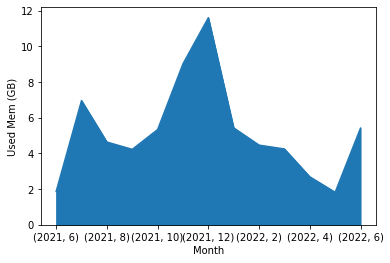

In [57]:
# This only uses the results data computed by Dask, so it should not launch any new parallel work
r.plot.area(xlabel = 'Month', ylabel = 'Used Mem (GB)')

#### Nice, but what did Dask do?

In [58]:
# Requires ipywidgets
t.dask

HighLevelGraph with 14 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x2b03877828c0>
 0. read-csv-7c70ba55a2169811691679ebd2b424b1
 1. getitem-825481280d50823c671d727c5458dea6
 2. eq-d0b7be936be9e8f491c99a72fc0ef84f
 3. getitem-034086537a1fb2e884c671a5f88d8448
 4. getitem-adcdad1ed4b58fce2f5386042b4c6e21
 5. dt-month-6fa950ad74d1a27b52236962e81ca386
 6. dt-year-baa673a21997d20ccd19b0220c8429b2
 7. dataframe-groupby-count-chunk-432a9317fe169cce5ddcad73cf60233a-8084d7f8bd9e5fbd79d5c2c3f3024c90
 8. dataframe-groupby-count-agg-432a9317fe169cce5ddcad73cf60233a
 9. getitem-72edc065c7e401e043d7360ef8579520
 10. dataframe-groupby-sum-chunk-4a8766161bc7e5ecedd1cf6bd77c74b6-a002bbe31550af9e5835c36404d8a044
 11. dataframe-groupby-sum-agg-4a8766161bc7e5ecedd1cf6bd77c74b6
 12. truediv-87fccbdb64b265c48214d312f59dcfe0
 13. getitem-9eb2bb681d7d58a1dc67ce47768b02a6

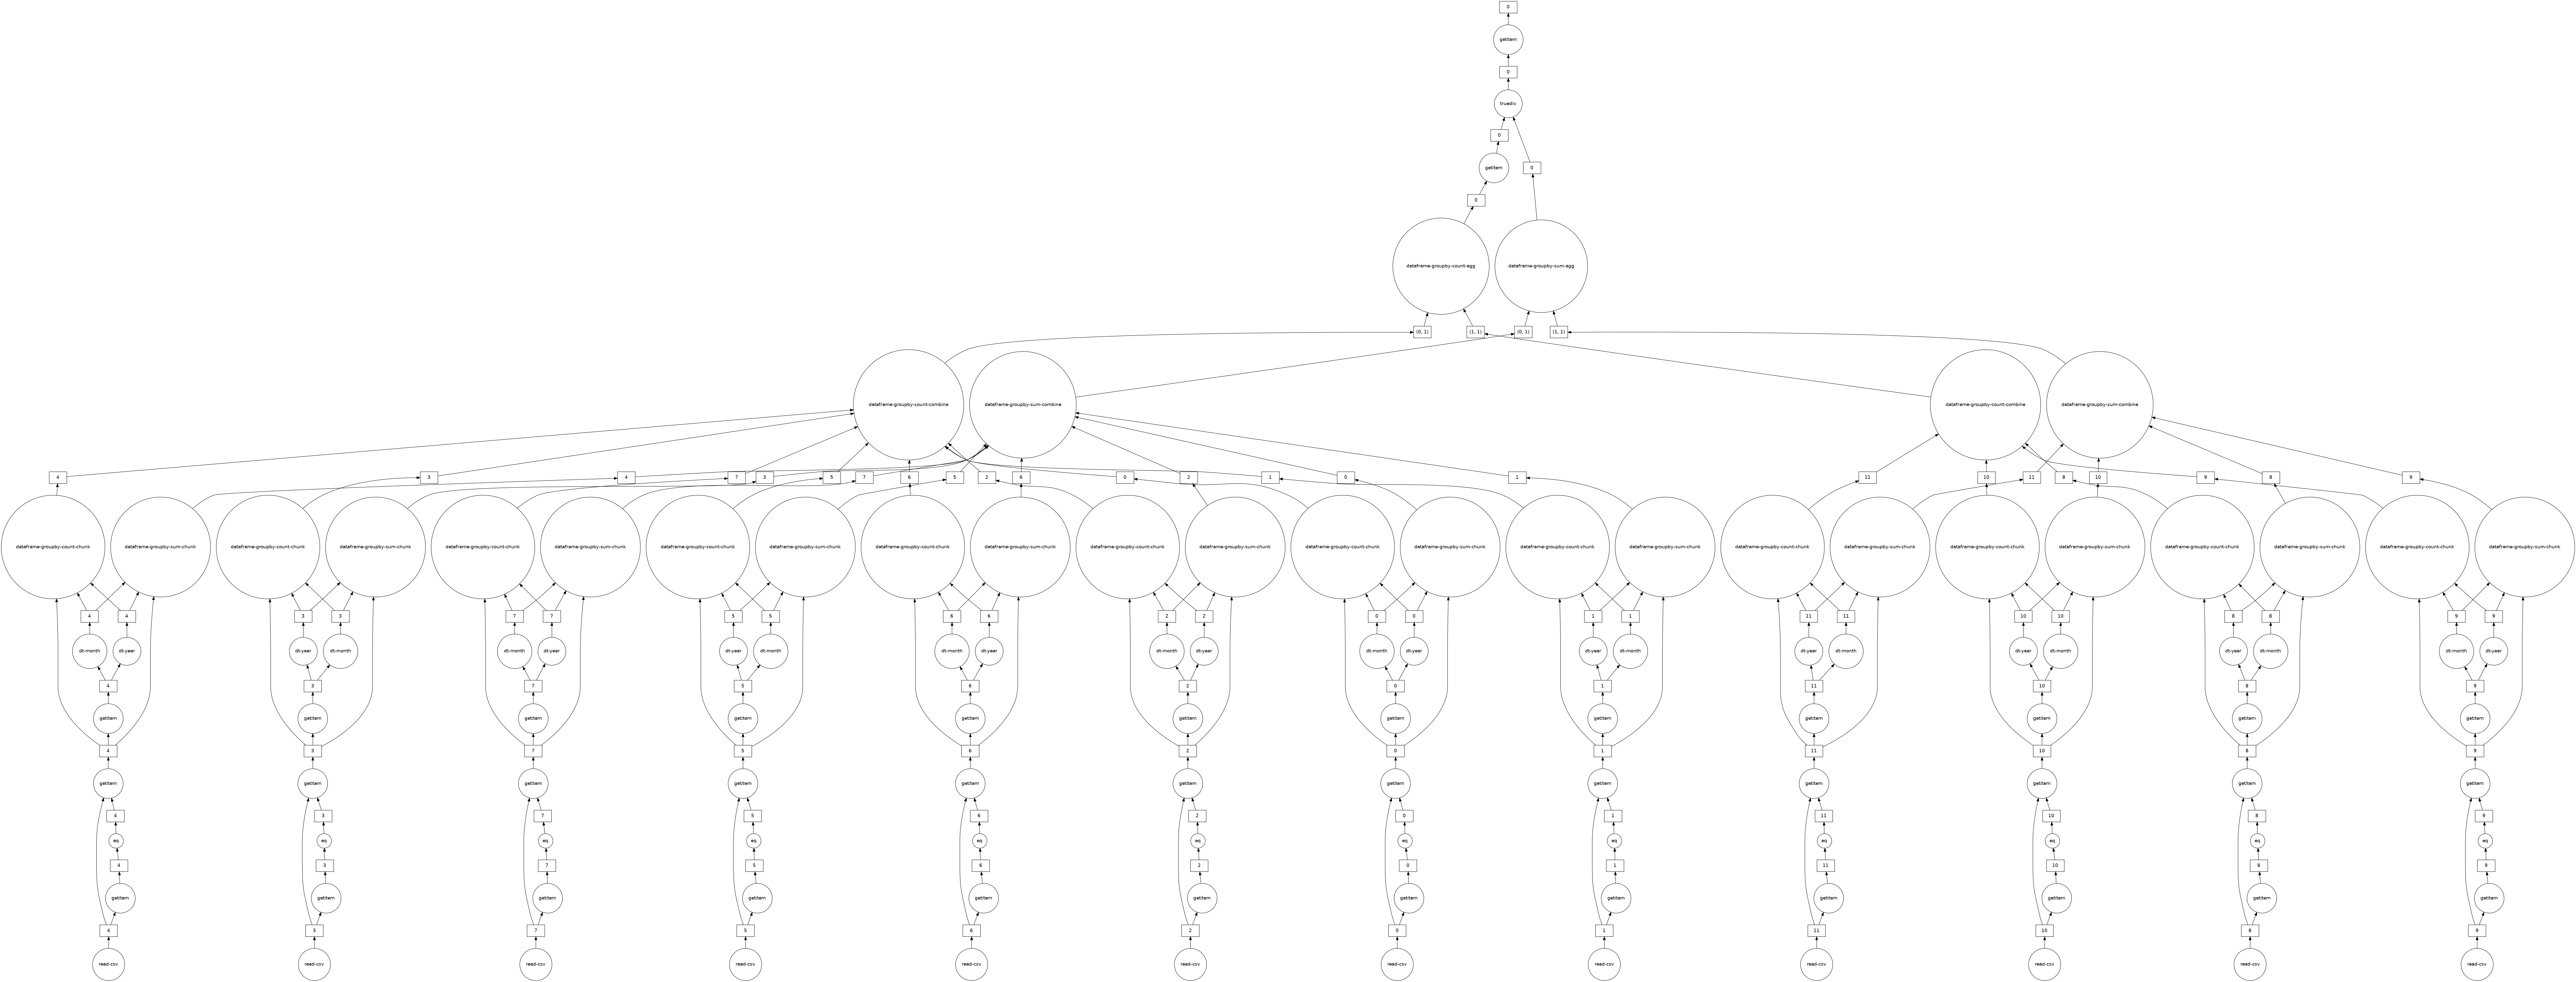

In [59]:
# Requires python-graphviz (not pygraphviz!)
t.visualize()

Using a client with a `LocalCluster` gives us more insight and control over the simple thread pool approach

* Set number of workers and threads-per-worker
* *Plus many other configuration options!*
* See the client / cluster diagnostics HTML page

In [60]:
# Shutdown the client & local cluster
client.shutdown()

---
## Using Dask on an HPC cluster

Fundamentally, the only thing we need to do to switch to a cluster environment is provide Dask with a way to access workers on other hosts.

So we switch from a `LocalCluster` to a distributed one that uses SSH, Kubernetes, or a batch scheduler to access worker resources. Typical HPC environments will use  *Slurm*, *PBS*, *LSF*, etc.

#### `dask-jobqueue` provides batch cluster types

```
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(processes=1,
                       threads=2,
                       memory="10GB",
                       project="ABC1234",
                       walltime="01:00:00",
                       queue="htc")
```

This provides a template with which the Dask and batch schedulers can spin up workers.


#### Let's start a PBS Cluster
*The following cells are designed to run on the Casper system at NCAR. The steps from here on out will need to be modified for your particular system.*

In [61]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client

In [63]:
cluster = PBSCluster(
     cores=1,
     memory='2GiB',
     processes=1,
     local_directory='$TMPDIR/dask/spill',
     resource_spec='select=1:ncpus=1:mem=2GB',
     queue='casper',
     walltime='10:00',
     interface='ib0'
)

#### Validate the configuration by printing the job script

In [64]:
print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q casper
#PBS -A SCSG0001
#PBS -l select=1:ncpus=1:mem=2GB
#PBS -l walltime=10:00
#PBS -e dask-worker-logs/
#PBS -o dask-worker-logs/
#PBS -j oe

/glade/work/vanderwb/conda-envs/my-dask-env/bin/python -m distributed.cli.dask_worker tcp://10.12.206.56:42999 --nthreads 1 --memory-limit 2.00GiB --name dummy-name --nanny --death-timeout 60 --local-directory $TMPDIR/dask/spill --interface ib0



Things I'm looking for:
1. PBS resource request matches what I'm assigning to the worker (e.g., memory units!)
2. Where are my job logs going? (for debugging)
3. Are there configuration settings I didn't expect?

#### Scaling the batch cluster

By default, our `PBSCluster` starts with no active workers. We need to *scale* the cluster up to fit our needs. Clusters can be scaled number or resource. The following are equivalent:
```
cluster.scale(4)
cluster.scale(cores=4)
cluster.scale(memory='8 GB')
```
Running these commands will immediately submit batch jobs to start workers, so it's typical to wait until we're ready to do work...

In [65]:
#client = Client(cluster)
# It can be nice to wait longer for client success on busy / sluggish systems
client = Client(cluster, timeout="60s")

In [66]:
# Lets use our job scheduler to watch the workers spin up
!qstat -u vanderwb

                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
3720296.casper* vanderwb htc      STDIN      268212   1   4   10gb 03:00 R 01:13

Cached at: Wed Aug  3 21:39:45 MDT 2022


In [67]:
# The wait blocks our notebook until the workers are ready - a synchronization point
cluster.scale(4)
client.wait_for_workers(4)
client.ncores()

{'tcp://10.12.206.54:34751': 1,
 'tcp://10.12.206.54:38437': 1,
 'tcp://10.12.206.54:40598': 1,
 'tcp://10.12.206.54:40744': 1}

In [68]:
!qstat -u vanderwb

                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
3720296.casper* vanderwb htc      STDIN      268212   1   4   10gb 03:00 R 01:13
3720436.casper* vanderwb htc      dask-work* 162110   1   1    2gb 00:10 R 00:00
3720437.casper* vanderwb htc      dask-work* 162179   1   1    2gb 00:10 R 00:00
3720438.casper* vanderwb htc      dask-work* 162477   1   1    2gb 00:10 R 00:00
3720439.casper* vanderwb htc      dask-work* 162546   1   1    2gb 00:10 R 00:00

Cached at: Wed Aug  3 21:40:36 MDT 2022


#### Now, let's again find the busiest day in our logs

In [69]:
job_files = glob.glob('data/jobs-*.dat')
djj = dd.read_csv(job_files, parse_dates = time_cols, na_values = '-')
top_day = djj.groupby(djj['Job Start'].dt.date).size()

In [70]:
%%time
r = top_day.compute()
r.agg(['idxmax','max'])

CPU times: user 184 ms, sys: 34.5 ms, total: 218 ms
Wall time: 6.6 s


idxmax    2022-01-17
max           170677
dtype: object

#### What if we double the size of our cluster?

In [71]:
cluster.scale(8)
client.wait_for_workers(8)
client.ncores()

{'tcp://10.12.206.54:34751': 1,
 'tcp://10.12.206.54:38437': 1,
 'tcp://10.12.206.54:39212': 1,
 'tcp://10.12.206.54:40598': 1,
 'tcp://10.12.206.54:40744': 1,
 'tcp://10.12.206.54:41870': 1,
 'tcp://10.12.206.54:45973': 1,
 'tcp://10.12.206.54:46269': 1}

*Are we creating 8 new workers here?*

In [72]:
%%time
r = top_day.compute()
r.agg(['idxmax','max'])

CPU times: user 107 ms, sys: 15.8 ms, total: 123 ms
Wall time: 3.7 s


idxmax    2022-01-17
max           170677
dtype: object

In [74]:
# It's always a good idea to scale down when done - otherwise we waste compute resources
cluster.scale(0)
client.ncores()

{}

In [75]:
client.shutdown()

#### Clusters can also adaptively scale

For interactive, exploratory work, *adaptive scaling* can be useful. This allows the cluster to dynamically scale up and down based on the (Dask) scheduler's estimation of resource needs. This capability is highly customizable, but one basic method would be to set bounds on the number of worker jobs that can be used:
```
cluster.adapt(minimum=0, maximum=12)
```

### Performance Considerations
* Ideally, you want to have more partitions than workers (*and evenly divisible!*) so that no workers remain idle for long
* Using **processes** for workers avoids issues with Python's global interpretor lock (GIL) and is a reasonable default approach
* Using **threads** for workers may be beneficial when running libraries that bypass the GIL with compiled code like NumPy  
  *If you use threads, make sure you pay attention to settings like `OMP_NUM_THREADS` when using C extensions*
* Very deep task graphs (millions of tasks) can have overhead in the hours - use larger partitions if possible in this scenario
* When using a distributed cluster, manually **persist** reused data into worker memory (loading from RAM is much faster than disk)

```
# Here we persist the dataframe after setting the index, since that is a heavyweight operation we do not wish to repeat!
df = dd.read_csv(data_files)
df = df.set_index('timestep')
df = client.persist(df)

res1 = df.groupby('location').size().compute()
res2 = df.groupby('location').mean().compute()
```

### Configuring Dask
When scaling up from local (workstation) to distributed (HPC cluster) usage, it becomes very important to customize how Dask works. There are multiple ways to change configuration, from high to low precedence:

1. Runtime setting within Python itself
2. Environment variables before launching Python
3. User-specific YAML config file in `~/.config/dask`
4. python/etc/dask
5. /etc/dask or $DASK_ROOT_CONFIG if set

In [76]:
# YAML configuration settings can be retrieved from within Python too
from dask import config
config.refresh()
config.get('jobqueue.pbs')

{'name': 'dask-worker',
 'cores': 1,
 'memory': '2GiB',
 'processes': 1,
 'interface': 'ib0',
 'queue': 'casper',
 'walltime': '00:30:00',
 'resource-spec': '-l select=1:ncpus=1:mem=2GB',
 'death-timeout': 60,
 'local-directory': '/local_scratch/pbs.$PBS_JOBID/dask',
 'project': 'SCSG0001',
 'extra': [],
 'env-extra': [],
 'job-extra': ['-j oe'],
 'log-directory': 'dask-worker-logs'}

## Logs and tracking the cluster and worker state

A lot of information and debug output can be found in the worker logs. When using `dask-jobqueue`, these logs will be written to the job log location shown in the job script above. Write them to an easy to find location, and be mindful that you may generate a lot of files!

In [77]:
!ls dask-worker-logs

3719166.casper-pbs.OU  3719331.casper-pbs.OU  3720438.casper-pbs.OU
3719167.casper-pbs.OU  3719333.casper-pbs.OU  3720439.casper-pbs.OU
3719168.casper-pbs.OU  3719334.casper-pbs.OU  3720440.casper-pbs.OU
3719169.casper-pbs.OU  3719335.casper-pbs.OU  3720441.casper-pbs.OU
3719328.casper-pbs.OU  3719336.casper-pbs.OU  3720442.casper-pbs.OU
3719329.casper-pbs.OU  3720436.casper-pbs.OU  3720443.casper-pbs.OU
3719330.casper-pbs.OU  3720437.casper-pbs.OU


*Using a directory specific to the workflow, date, or job ID can help avoid log file confusion.*

You can also print out the logs from **active** workers using the following client method:
```
client.get_worker_logs()
```

#### Setting log verbosity
Dask uses standard Python logging levels, shown here from least to most verbose:  
```
CRITICAL -> ERROR -> WARNING -> INFO -> DEBUG
```
These settings can be set in YAML config files or in the script. For example:
```
logging:
  distributed.client: info
  distributed.nanny: info
  distributed.worker: debug
```

## Some observations from NCAR support

#### Workers take too long to start

For any number of reasons, workers may take a while to start, causing the `nanny` to terminate the worker and your cluster scaling to fail. You may see messages like this in your logs:
```
2022-07-19 14:25:10,663 - distributed.nanny - INFO - Closing Nanny at 'tcp://10.12.206.4:44646'.
2022-07-19 14:25:10,667 - distributed.nanny - INFO - Nanny asking worker to close
2022-07-19 14:25:13,617 - distributed.nanny - WARNING - Worker process still alive after 3.9999900817871095 seconds, killing
2022-07-19 14:25:13,674 - distributed.dask_worker - INFO - Timed out starting worker
2022-07-19 14:25:13,677 - distributed.dask_worker - INFO - End worker
```
**Solution:** increase the `death-timeout` parameter from 60 seconds to a higher number. Note that this parameter is used to terminate desync'd workers, so avoid setting it too high!

#### Worker is killed
```
KilledWorker: ('__call__-6af7aa29-2a09-45f3-a5e2-207c06562672', <Worker 'tcp://10.194.211.132:11927', memory: 0, processing: 1>) 
```

There are many possibilities here unfortunately, but common ones can include out-of-memory conditions (easier when spilling to disk is disabled) or running out of disk space/quota.

#### Running your Dask tasks serially is powerful in debugging
If you can temporarily switch to the non-distributed scheduler (e.g., you aren't using any asynchronous features like futures), you can run that one in single-thread mode. Then, you can use the Python debugger or the `%debug` cell magic in a notebook to examine the call stack upon an exception.
```
da.compute(scheduler="single-threaded")
```
[This StackOverflow post](https://stackoverflow.com/questions/44193979/how-do-i-run-a-dask-distributed-cluster-in-a-single-thread) gives detail on running the distributed scheduler with a single thread, but it is not as simple.

#### A not-insignificant number of errors are fixed by upgrading software...

## Suggested Best Practices

**General Dask use**
* Before starting, analyze whether your problem truly justifies Dask overhead
* If possible, prototype your code serially and then augment with distributed Dask

**Dask configuration**
* For reproducibility, ease of sharing, and clarity, put required settings in the script or notebook
* Quality of life and/or community standard practices can go in user YAML config file

**Larger scale considerations**
* Many workers can put high load on network file systems in spill situations; disable spill or use local storage
* Dask has *experimental* support for UCX for worker communication to use the full speed of a high-speed network

**Resource utilization**
* Choose generous memory defaults at first, **but then refine/reduce!**
* Avoiding swapping to disk as much as possible; swap causes MAJOR performance penalties
* Delete your cluster object once done with it to terminate idle worker jobs

**Job turnaround**
* Keep worker resource needs low: most times this will decrease scheduler wait times
* Use adaptive scaling during exploratory work and manually scale in production
* If your scheduler is tuned for large jobs, consider using [dask-mpi](http://mpi.dask.org/en/latest/) instead of dask-jobqueue

## Resources for further learning
* [Dask documentation](https://docs.dask.org/en/stable/)
* [Dask Distributed documentation](https://distributed.dask.org/en/stable/)
* [Dask-jobqueue documentation](https://jobqueue.dask.org/en/latest/)
* [Using Dask with GPUs](https://docs.dask.org/en/stable/gpu.html)

---
## Addendum: Using JupyterLab on HPC systems

Ideally, you have access to JupyterHub, which provides a web portal to notebooks, terminals, and Dask Distributed dashboards. If not, you will need to create SSH tunnels to forward the port for Jupyter *and, if desired, the Dask dashboard.*  

**Remote System**
```
conda activate my-dask-env
jupyter lab --no-browser [--port 8888]
```
**Local System**
```
ssh -N -L 8888:localhost:8888 remote.hpc.system.edu
```
Then, you would navigate to `http://localhost:8888` in your browser and sign into JupyterLab. Once you start a distributed dask cluster, you will then have its port number (8787 by default if unoccupied).  

Fortunately, you do not need to forward the Dask cluster port, as Jupyter can proxy it for you. You instead can use the following URL in your browser:
```
http://localhost:<jupyter_port>/proxy/<cluster_port>/status
```